<a href="https://colab.research.google.com/github/BlakeMilstead/COSC-302-Project-5/blob/main/StockBot_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install xgboost --quiet
!pip install --upgrade tensorflow --quiet
!pip install --upgrade keras --quiet
!pip install polygon-api-client --quiet
!pip install aiohttp --quiet
!pip install nest_asyncio --quiet
!pip install diskcache --quiet

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from polygon import RESTClient
import requests
import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import download
from requests.exceptions import HTTPError
import aiohttp
import asyncio
import nest_asyncio
from itertools import product
from diskcache import Cache
import os

In [3]:
api_key = 'WlyapBrEd4Rq_3c7UKjic7C13QSirasy'

In [21]:
from google.colab import drive
drive.mount('/content/drive')

# Now, use a folder in Google Drive as your cache location
cache_path = '/content/drive/MyDrive/StockBot/cache_directory'  # Path in Google Drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
download('vader_lexicon')
nest_asyncio.apply()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [28]:
class DataCollector:
    def __init__(self, api_key):
        self.api_key = api_key
        self.cache = Cache(cache_path) # Initialize cache

    def clear_cache(self):
        """
        Clears the cache and deletes cache files from the directory.
        """
        try:
            # Print cache status before clearing
            print(f"Cache before clearing. Number of items: {len(self.cache)}")
            cache_directory = self.cache.directory  # Get the cache directory

            # Clear the in-memory cache
            self.cache.clear()

            # Manually delete the cache files on disk
            if os.path.exists(cache_directory):
                for filename in os.listdir(cache_directory):
                    file_path = os.path.join(cache_directory, filename)
                    if os.path.isfile(file_path):
                        os.remove(file_path)  # Remove the file
                print(f"Cache files deleted from {cache_directory}.")
            else:
                print(f"Cache directory {cache_directory} not found.")

            # Print cache status after clearing
            print(f"Cache cleared. Number of items: {len(self.cache)}")
        except Exception as e:
            print(f"Error clearing cache: {e}")

    def check_cache_status(self):
        """
        Prints out the number of items in the cache and the current cache size.
        """
        try:
            print(f"Cache contains {len(self.cache)} items.")
            cache_size = sum([item[1] for item in self.cache.items()])
            print(f"Cache size: {cache_size / (1024 ** 2):.2f} MB")  # Display cache size in MB
        except Exception as e:
            print(f"Error checking cache: {e}")

    def create_stock_sentiment_df(self, ticker, days_back=365, decay_factor=0.95):
      client = RESTClient(api_key=self.api_key)
      today = datetime.date.today()
      from_date = today - datetime.timedelta(days=days_back)
      to_date = today

      aggs = self.make_api_call(client, ticker, from_date, to_date)
      if aggs is None:
          return pd.DataFrame()

      stock_df = pd.DataFrame(aggs).rename(columns={'timestamp': 'time'})
      stock_df['Datetime'] = pd.to_datetime(stock_df['time'], unit='ms', utc=True).dt.tz_convert('America/New_York')

      sia = SentimentIntensityAnalyzer()
      date_list = [row['Datetime'].strftime('%Y-%m-%d') for _, row in stock_df.iterrows()]

      loop = asyncio.get_event_loop()
      sentiments = loop.run_until_complete(self.fetch_all_news(ticker, self.api_key, date_list, sia))


      for idx, val in enumerate(sentiments):
          if isinstance(val, (list, tuple)) and len(val) == 2 and val[0] is not None:
              # Store the average sentiment
              stock_df.loc[idx, 'sentiment'] = val[0]
              # Store the number of articles in a new column
              stock_df.loc[idx, 'num_articles'] = val[1]
          else:
              stock_df.loc[idx, 'sentiment'] = 0  # Default for missing sentiments
              stock_df.loc[idx, 'num_articles'] = 0 # Default for missing articles

      return stock_df

    async def fetch_all_news(self, ticker, api_key, date_list, sia):
      base_url = "https://api.polygon.io/v2/reference/news"
      params = {
          'ticker': ticker,
          'published_utc.gte': f"{date_list[0]}T00:00:00Z",
          'published_utc.lte': f"{date_list[-1]}T23:59:59Z",
          'limit': 1000,
          'apiKey': api_key
      }

      cache_key = f"{ticker}_{date_list[0]}_{date_list[-1]}"
      if cache_key in self.cache:
          return self.cache[cache_key]

      timeout = aiohttp.ClientTimeout(total=60)  # Set a timeout of 60 seconds
      max_retries = 50  # Number of retries for failures

      for attempt in range(max_retries):
          try:
              async with aiohttp.ClientSession(timeout=timeout) as session:
                  async with session.get(base_url, params=params) as response:
                      if response.status == 429:
                          print(f"Rate limit hit for {ticker}. Retrying in 60 seconds...")
                          await asyncio.sleep(60)
                          continue  # Retry after sleep
                      elif response.status != 200:
                          error_details = await response.text()
                          print(f"Failed to fetch news for {ticker}. HTTP Status: {response.status}, Details: {error_details}")
                          return [0] * len(date_list)

                      data = await response.json()
                      articles = data.get('results', [])

                      # Process articles and calculate sentiment
                      results = {}
                      for article in articles:
                          published_date = article['published_utc'][:10]
                          if published_date not in results:
                              results[published_date] = []
                          results[published_date].append(article)

                      final_results = []
                      for date_string in date_list:
                          date_articles = results.get(date_string, [])
                          if not date_articles:
                              final_results.append([None, None])
                          else:
                              articles_df = pd.DataFrame(date_articles)
                              articles_sentiment = self.analyze_sentiment(articles_df, 'title', sia)
                              avg_sent = self.average_sentiment_score(articles_sentiment)
                              final_results.append([avg_sent, len(date_articles)])

                      self.cache[cache_key] = final_results
                      return final_results
          except asyncio.TimeoutError:
              print(f"Timeout occurred on attempt {attempt + 1} for {ticker}. Retrying...")
              await asyncio.sleep(10)  # Delay before retrying
          except aiohttp.ClientError as e:
              print(f"Client error: {e}. Retrying...")
              await asyncio.sleep(10)

      print(f"Failed to fetch news for {ticker} after {max_retries} attempts.")
      return [0] * len(date_list)  # Return default values if all retries fail



    def analyze_sentiment(self, data, column, sia):

        # Applying sentiment analysis to the specified column and extracting compound score
        data['sentiment'] = data[column].apply(lambda x: sia.polarity_scores(x)['compound'])

        # Classify sentiment as Positive, Negative, or Neutral
        data['sentiment_label'] = data['sentiment'].apply(lambda x: 'Positive' if x > 0.05 else ('Negative' if x < -0.05 else 'Neutral'))

        return data

    # Function to calculate the average sentiment score
    def average_sentiment_score(self, data):
        average_sentiment = data['sentiment'].mean()  # Calculate the mean (average) of all compound sentiment scores
        return average_sentiment

    def make_api_call(self, client, ticker, from_date, to_date):
        # Function to make the API call with retries
        attempts = 0
        while attempts < 3:  # Retry up to 3 times
            try:
                aggs = client.list_aggs(
                    ticker=ticker,
                    multiplier=1,
                    timespan="day",
                    from_=from_date,
                    to=to_date,
                    limit=50000  # Adjust limit as needed
                )
                return aggs  # Return the data if successful
            except HTTPError as e:
                if e.response.status_code == 429:  # Rate limit error
                    print(f"Rate limit hit for {ticker}. Retrying in 60 seconds...")
                    time.sleep(60)  # Wait for 60 seconds
                    attempts += 1
                else:
                    raise  # Raise other errors for handling outside
        print(f"Failed to fetch data for {ticker} after multiple retries.")
        return None  # Return None if all retries fail

In [6]:
class stock_bot():

    def __init__(self, ticker, random_state, data, features=None):
        if features is None:
          features = ['open', 'high', 'low', 'close', 'volume', 'sentiment']
        self.features = features
        self.ticker = ticker
        self.random_state = random_state
        self.models = {}

        self.data = data

    def get_features(self, target):
        return [f for f in self.features if f != target]

    def train_models(self, data, params):
        for target in self.features:
            X = data[self.get_features(target)]
            y = data[target]
            self.train(X, y, target, params)

        return self.models

    def train(self, X, y, target, params=None):

        if params is None:
            params = {
                'objective': 'reg:squarederror',
                'n_estimators': 100,
                'learning_rate': 0.1,
                'max_depth': 3
            }

        model = xgb.XGBRegressor(**params)
        model.fit(X, y)

        self.models[target] = model

        return model

    def plot(self, model):
        plt.figure(figsize=(12, 6))
        plt.plot(self.data['Datetime'], self.data['close'], label='Actual Stock Price', color='blue')

        plt.plot(self.data['Datetime'], model.predict(self.data[self.features]), label='Predicted Stock Price', color='red')
        plt.title(f'Stock Price Prediction for {self.ticker}')
        plt.xlabel('Date')
        plt.ylabel('Stock Price')
        plt.legend()

    def predict_day(self, yesterday):
        today = {}
        y_data_open = yesterday[self.get_features('open')]

        # Reshape the features into a 2D array for prediction
        t_open_pred = y_data_open.values.reshape(1, -1)

        # Predict the 'open' price using the appropriate model
        today_open = self.models['open'].predict(t_open_pred)[0]

        today['open'] = today_open

        for target in self.features:
          if target != 'open' and target != 'close':
            model = self.models[target]
            target_features = self.get_features(target)
            last_day_target = yesterday[target_features].copy()
            last_day_target['open'] = today['open']

            last_day_target_pred = last_day_target.values.reshape(1, -1)
            # Predict the target price using the appropriate model
            today_target = model.predict(last_day_target_pred)[0]

            today[target] = today_target

        close_model = self.models['close']
        today_close = close_model.predict(pd.DataFrame([today]))[0]
        today['close'] = today_close

        idx = range(len(self.features) - 1)

        today = pd.DataFrame([today], columns=self.features)

        return today

    def predict_past(self, days):
        days = days + 1
        real_days = self.data.tail(days).reset_index(drop=True)
        last_day = real_days.iloc[0]

        data = {}
        closes = []

        for i in range(days):
          today = self.predict_day(last_day)
          data[i] = today
          closes.append(data[i]['close'])
          last_day = today

        return data, closes

    def plot_past(self, lookback, closes):
        days = len(closes)
        real_days = self.data.tail(lookback + days)['close'].reset_index(drop=True)

        dates = np.linspace(1, lookback+days-1, lookback+days-1, dtype=int)
        days_past = dates[:lookback]
        days_future = dates[lookback-1:]

        closes[0] = real_days[days_future].head(1)

        plt.figure(figsize=(12, 6))
        plt.plot(days_past, real_days[days_past], label='Real Past Prices', color='blue')
        plt.plot(days_future, real_days[days_future], label='Real Future Prices', color='green')
        plt.plot(days_future, closes, label='Predicted Closing Prices', color='red')
        plt.title(f'{len(closes)-1} Day Closing Price Prediction for {self.ticker}')
        plt.xlabel('Days')
        plt.ylabel('Closing Price')
        plt.legend()

        plt.show()

    def predict_x(self, x):
        real_days = self.data.tail(1).reset_index(drop=True)
        last_day = real_days.iloc[0]

        data = {}
        closes = []

        for i in range(x):
          today = self.predict_day(last_day)
          data[i] = today
          closes.append(data[i]['close'])
          last_day = today

        return data, closes

    def plot_x(self, days_b4, closes):
        # Extract real closing prices for the specified number of days before prediction
        real_days = self.data.tail(days_b4)['close'].reset_index(drop=True)

        # Concatenate the last real price with the predicted prices for seamless connection
        closes = np.insert(closes, 0, real_days.iloc[-1])  # Add the last real closing price to the predictions

        # Create x-axis for real and predicted values
        dates = np.linspace(1, len(closes) + days_b4 - 1, len(closes) + days_b4 - 1)

        # Plot both segments
        plt.figure(figsize=(12, 6))
        plt.plot(dates[:days_b4], real_days, label='Real Closing Prices', color='blue')  # Real prices
        plt.plot(dates[days_b4-1:], closes, label='Predicted Closing Prices', color='red')  # Predicted prices

        # Plot settings
        plt.title(f'{len(closes) - 1} Day Closing Price Prediction for {self.ticker}')
        plt.xlabel('Days')
        plt.ylabel('Closing Price')
        plt.legend()

        plt.show()

In [7]:
class stock_bot_tester():
    def __init__(self, ticker, data_collector, days_back, random_state, features=None):
        if features is None:
          features = ['open', 'high', 'low', 'close', 'volume', 'sentiment']
        self.param_grid = {
            'objective': ['reg:squarederror'],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'n_estimators': [50, 100, 150],
        }
        self.ticker = ticker
        self.data_collector = data_collector
        self.api_key = api_key
        self.days_back = days_back
        self.random_state = random_state
        self.features = features

        self.data = self.data_collector.create_stock_sentiment_df(self.ticker, self.days_back)[self.features]

    def get_features(self, target):
        return [f for f in self.features if f != target]

    def train_and_evaluate(self, data, params, n_splits=3):
        kval = KFold(n_splits=n_splits)
        validation_scores = []

        for train_idx, val_idx in kval.split(data):
            data_train = data.iloc[train_idx]
            data_val = data.iloc[val_idx]

            bot = stock_bot(self.ticker, self.random_state, self.data)
            model = bot.train_models(data_train, params)

            y_pred = model['close'].predict(data_val[self.get_features('close')])
            score = np.sqrt(mean_squared_error(data_val['close'], y_pred))
            validation_scores.append(score)

        return np.mean(validation_scores)

    def hyperparameter_search(self):
        best_score = float('inf')
        best_params = None
        results = []

        # Generate all combinations of hyperparameters
        param_combinations = list(product(*self.param_grid.values()))

        for combination in param_combinations:
            params = dict(zip(self.param_grid.keys(), combination))
            print(f"Testing parameters: {params}")

            score = self.train_and_evaluate(self.data, params)
            results.append((params, score))

            if score < best_score:
                best_score = score
                best_params = params

        return best_params, best_score, results

In [31]:
data_collector = DataCollector(api_key)
data_collector.clear_cache()
bot_tester = stock_bot_tester('TSLA', data_collector, 365, 42)

best_params, best_score, results = bot_tester.hyperparameter_search()

Cache before clearing. Number of items: 1
Cache files deleted from /content/drive/MyDrive/StockBot/cache_directory.
Cache cleared. Number of items: 0
Testing parameters: {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Testing parameters: {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100}
Testing parameters: {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150}
Testing parameters: {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50}
Testing parameters: {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 100}
Testing parameters: {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 150}
Testing parameters: {'objective': 'reg:squarederror', 'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 50}
Testing parameters: {'objective': 'reg:squarederror', '

In [34]:
print(bot_tester.data.tail())

        open      high     low   close       volume  sentiment
246  340.730  348.5499  330.01  338.74  123345498.0   0.046675
247  335.760  347.3799  332.75  346.00   88501177.0   0.765000
248  345.000  346.5999  334.30  342.03   64842707.0  -0.016700
249  343.810  347.9899  335.28  339.64   57790226.0   0.000000
250  341.085  361.5300  337.70  352.56   88350753.0   0.418333


Model achieved 12.46 validation MSE


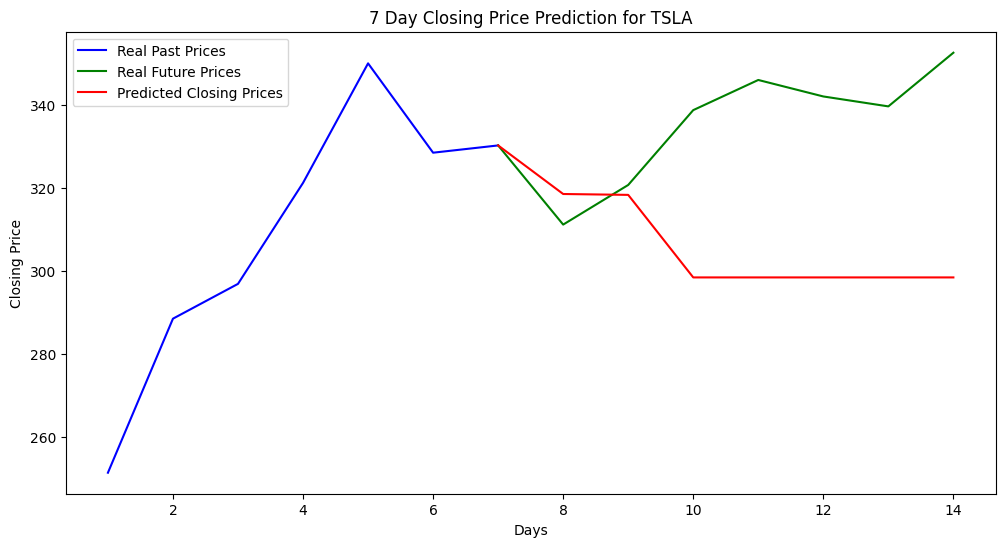

In [10]:
stock_bot_best = stock_bot('TSLA', 42, bot_tester.data)

stock_bot_best.train_models(bot_tester.data, best_params)

week, week_close = stock_bot_best.predict_past(7)

print(f'Model achieved {best_score:.2f} validation MSE')

stock_bot_best.plot_past(7, week_close)

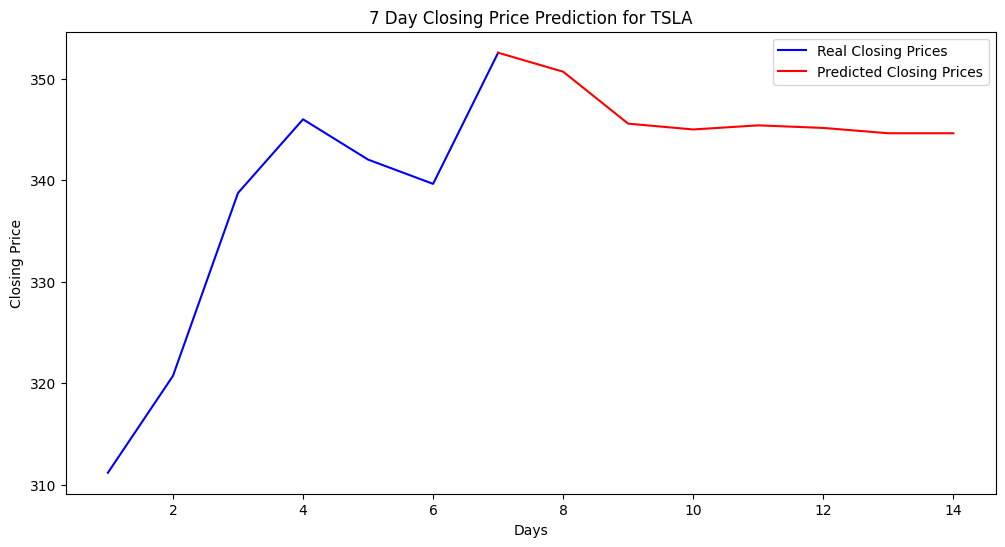

In [11]:
week, week_close = stock_bot_best.predict_x(7)

stock_bot_best.plot_x(7, week_close)